In [1]:
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import glob
from tqdm import tqdm
sys.path.append(os.path.abspath("../.."))
import openpyxl
from sklearn.preprocessing import OneHotEncoder
from multiprocessing import Pool
from scipy.signal import decimate
from umap import UMAP
from pathlib import Path
from utils.audio_io import load_audio
from utils.plot_utils import plot_takens_embedding, plot_winding_xy
from preprocessing.signal_processing.preprocessing import preprocess_signal, prepare_signal
from preprocessing.features.winding import get_winding_curve
from preprocessing.signal_processing.fourier import apply_fft, get_dominant_frequencies
from preprocessing.features.its import extract_its
from preprocessing.features.features_extractor import extract_features_from_segmented_signal
from preprocessing.features.mfcc import extract_mfcc_features
from preprocessing.features.wavelet import  extract_wavelet_features
from preprocessing.segment_signal import segment_signal
from preprocessing.features.takens_rqa import extract_rqa_features_smart, extract_rqa_features
%matplotlib inline

# **Geração do Dataset cru**
### Nesta etapa, geramos o dataset "cru", i.e. , a base de dados pronta e que antecede as etapas de exploração e pré-processamento propriamente dito. Neste caso, estamos apenas preparando os dados.

In [2]:
# CAMINHOS DOS RÓTULOS
df_rotulos_mix = pd.read_csv(
    '../../data/raw/HeartANDLung_Sounds_Dataset/Mix.csv', sep=';')
df_rotulos_hs = pd.read_csv(
    '../../data/raw/HeartANDLung_Sounds_Dataset/HS.csv', sep=',')
df_rotulos_ls = pd.read_csv(
    '../../data/raw/HeartANDLung_Sounds_Dataset/LS.csv', sep=';')

# CAMINHOS DOS ARQUIVOS DE ÁUDIO
arquivos_mix = "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/M*.wav"
arquivos_hs_fromMix = "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/H*.wav"
arquivos_ls_fromMix = "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/L*.wav"

arquivos_HS = "../../data/raw/HeartANDLung_Sounds_Dataset/HS/HS/*.wav"
arquivos_LS = "../../data/raw/HeartANDLung_Sounds_Dataset/LS/LS/*.wav"

In [3]:
def extrair_features_topologicas(wav_path):
     """
     Aplica FFT, ITS, RQA e outras extrações sobre um .wav e retorna um DataFrame por janela.
     """
     fs, signal = load_audio(wav_path) 

     signal, fs = prepare_signal(
         signal, fs, max_audio_duration=15, decimation_factor=5, use_kalman=False)

     df_topologico = extract_features_from_segmented_signal(
          signal=signal,
          fs=fs,
         file_id=wav_path,
          extract_its_fn=extract_its,
          fft_fn=apply_fft,
          get_dom_freqs_fn=get_dominant_frequencies,
          extract_mfcc_fn=extract_mfcc_features,
          #extract_wavelet_fn=extract_wavelet_features,
          extract_rqa_fn=extract_rqa_features,
         window_duration_sec=2.5,
          overlap=0.74,
          threshold=0.2,
         winding_duration=2,
          n_mfcc=13
          )
     """ 
     Tratando os missing values em colunas RQA à priori
     """
     # Substituir NaN por -1 somente em colunas RQA
     rqa_cols = [col for col in df_topologico.columns if col.startswith(
     "rqa_") and df_topologico[col].isna().any()]
     df_topologico[rqa_cols] = df_topologico[rqa_cols].fillna(-1)
     # Criar flag binária
     df_topologico["has_trapping"] = (
     df_topologico["rqa_trapping_time"] != -1).astype(int)
          
     return df_topologico

In [4]:
def calcular_num_janelas(fs, duration, window_duration_sec, overlap):
     total_samples = float(fs * duration)
     window_size = float(window_duration_sec * fs)
     hop_size = float(window_size * (1 - overlap))
     return (total_samples - window_size) // hop_size + 1


# Exemplo
decimation_factor = 5
fs = 44100 // decimation_factor
print(calcular_num_janelas(fs, 15.0, 2.8, 0.74))


17.0


In [5]:
def extrair_todas_as_features(wav_path, mix_df , id_column_name):
     """
     Processa 1 arquivo wav e retorna um DataFrame com features + rótulos.
     """
     base_id = os.path.basename(wav_path).replace('.wav', '')
     df_feat = extrair_features_topologicas(wav_path)

     # Pegando os metadados
     meta = mix_df[mix_df[id_column_name] == base_id].iloc[0]
     for col in meta.index:
          df_feat[col] = meta[col]

     return df_feat

In [ ]:

# teste_features_mix = extrair_todas_as_features(
#     "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix_teste/M0006.wav", df_rotulos_mix, 'Mixed Sound ID')

# teste_features_hs = extrair_todas_as_features(
#     "../../data/raw/HeartANDLung_Sounds_Dataset/HS/HS/F_AF_A.wav", df_rotulos_hs, 'Heart Sound ID')

In [ ]:
# teste_features_hs.to_excel("teste_F_AF_A.xlsx", index=False)

#### Função que gera o dataset consolidado ainda sem decodificação

In [6]:
def create_initial_dataset(path_audio_files: str, df_rotulos: pd.DataFrame, id_column_name: str):
    arquivos = sorted(glob.glob(path_audio_files))
    dfs = []
    for path in tqdm(arquivos):
        try:
            df = extrair_todas_as_features(path, df_rotulos, id_column_name)
            dfs.append(df)
        except Exception as e:
            print(f"Erro no {path}: {e}")
    
    df_final = pd.concat(dfs, ignore_index=True)
    
    return df_final

#### função para decodificação one-hot

In [7]:
def remove_columns(df: pd.DataFrame, columns_to_remove: list):
    return df.drop(columns=columns_to_remove, errors='ignore')

In [8]:

def create_one_hot_encoded_df(df: pd.DataFrame, tipo: str) -> pd.DataFrame:
    """
    Codifica apenas as colunas categóricas relevantes:
    - LS: 'Gender', 'Location' (ignora 'Heart Sound Type')
    - HS: 'Gender', 'Location' (ignora 'Lung Sound Type')
    - Mix: 'Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location'
    """
    df = remove_columns(df, ['file_id', 'rqa_file_id', 'rqa_window_id'])
    
    colunas_para_codificar = ['Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location']
    
    # Define colunas específicas para cada tipo
    if tipo.upper() == "HS":
        colunas_para_codificar.remove("Lung Sound Type")
        del df['Heart Sound ID']
    elif tipo.upper() == "LS":
        colunas_para_codificar.remove("Heart Sound Type")
        del df['Lung Sound ID']
    else:
        if tipo.upper() != "MIX":
            raise ValueError(f"Tipo inválido: {tipo}. Use 'HS', 'LS' ou 'Mix'.")
        df.drop(columns=["Heart Sound ID", "Lung Sound ID"])

    # Verifica quais colunas realmente existem no DataFrame
    colunas_existentes = [
        col for col in colunas_para_codificar if col in df.columns]

    if not colunas_existentes:
        print("Nenhuma coluna categórica válida encontrada para codificação.")
        return df

    # Codifica apenas as colunas permitidas
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded = encoder.fit_transform(df[colunas_existentes])

    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(
        colunas_existentes), index=df.index)

    # Junta com o DataFrame original (removendo só as colunas codificadas)
    df_final = pd.concat(
        [df.drop(columns=colunas_existentes), encoded_df], axis=1)

    return df_final

### Criando os datasets iniciais sem codificação

In [17]:
# df_sem_cod_LS_fromMix = create_initial_dataset(arquivos_ls_fromMix, df_rotulos_mix, "Lung Sound ID")
# df_sem_cod_LS_fromMix.to_csv("../../datasets/intermediate/dataset_semCodificacao_LSFromMix.csv", index=False)

In [18]:
# df_sem_cod_HS_fromMix = create_initial_dataset(arquivos_hs_fromMix, df_rotulos_mix, "Heart Sound ID")
# df_sem_cod_HS_fromMix.to_csv(

#     "../../datasets/intermediate/dataset_semCodificacao_HSFromMix.csv", index=False)

In [19]:
# df_sem_cod_Mix = create_initial_dataset(arquivos_mix, df_rotulos_mix, "Mixed Sound ID")
# remove_columns(df_sem_cod_Mix, ['window_id', 'rqa_window_id'])
# df_sem_cod_Mix.to_csv("../../datasets/intermediate/dataset_semCodificacao_Mix.csv", index=False)

In [9]:
df_sem_cod_HS = create_initial_dataset(arquivos_HS, df_rotulos_hs, "Heart Sound ID")
df_sem_cod_HS.to_csv(
    "../../datasets/intermediate/dataset_semCodificacao_HS_20windows.csv", index=False)

100%|██████████| 50/50 [59:28<00:00, 71.37s/it]   


In [20]:
# df_sem_cod_LS = create_initial_dataset(arquivos_LS, df_rotulos_ls, "Lung Sound ID")
# df_sem_cod_LS.to_csv(

#     "../../datasets/intermediate/_dataset_semCodificacao_LS.csv", index=False)

### Aqui já podemos adiantar a decodificação _One-Hot_ do dataset geral

In [10]:
df_codificado_HS = create_one_hot_encoded_df(df_sem_cod_HS, "HS")
df_codificado_HS.to_csv(
    "../../datasets/intermediate/dataset_codificado_HS_20windows.csv", index=False)

In [ ]:

# df_codificado_LS = create_one_hot_encoded_df(df_sem_cod_LS, "LS")
# df_codificado_LS.to_csv(
#     "../../datasets/intermediate/_dataset_codificado_LS.csv", index=False)

# df_codificado_Mix = create_one_hot_encoded_df(df_sem_cod_Mix, "Mix")
# df_codificado_Mix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_Mix.csv", index=False)

# df_codificado_HS_fromMix = create_one_hot_encoded_df(df_sem_cod_HS_fromMix, "HS")
# df_codificado_HS_fromMix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_HSFromMix.csv", index=False)

# df_codificado_LS_fromMix = create_one_hot_encoded_df(df_sem_cod_LS_fromMix, "LS")
# df_codificado_LS_fromMix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_LSFromMix.csv", index=False)

### Agregação dos dados

In [2]:
df_sem_cod_HS = pd.read_csv("../../datasets/intermediate/dataset_semCodificacao_HS.csv", sep=',')

In [7]:
df_sem_cod_HS.describe

<bound method NDFrame.describe of              freq  centro_x  centro_y  raio_medio  raio_std  raio_max  \
0       26.333333 -0.001474 -0.000010    0.030464  0.029598  0.220518   
1       26.666667  0.001152  0.001593    0.030498  0.029534  0.222931   
2       27.333333  0.001188 -0.002174    0.030514  0.029479  0.223943   
3       27.666667 -0.001482 -0.001820    0.030453  0.029553  0.223565   
4       28.333333 -0.001282  0.000907    0.030516  0.029539  0.222728   
...           ...       ...       ...         ...       ...       ...   
76310  103.333333  0.006859  0.022406    0.100246  0.135903  0.671129   
76311  103.666667  0.011593 -0.014532    0.098132  0.138176  0.692598   
76312  108.333333 -0.009926  0.000141    0.095319  0.141010  0.681254   
76313  118.666667 -0.008140  0.009960    0.096190  0.140178  0.681391   
76314  123.666667 -0.004997 -0.012466    0.096515  0.139902  0.681139   

       raio_min  simetria_x  simetria_y  densidade_nucleo  ...  \
0      0.000410    0.03

In [11]:
df_heart_full = df_sem_cod_HS.copy()
df_heart_full = remove_columns(df_heart_full, ['file_id', 'rqa_file_id', 'rqa_window_id'])

# Agrupar por (file_id, window_id)
group_cols = ["Heart Sound ID", "window_id"]

# Colunas categóricas para preservar
categorical_cols = [col for col in df_heart_full.columns if any(
    prefix in col for prefix in ["Gender", "Heart Sound Type", "Location"])]

# Colunas numéricas candidatas
numeric_cols = [
    col for col in df_heart_full.columns if col not in categorical_cols + group_cols]

# Filtrar quais variáveis realmente podem ter std() útil (ITS, freq, etc.)
std_exclude_keywords = [
    "mfcc_", "entropy", "sample_entropy", "band_energy", "spectral", "rqa_",
    "zero_crossing", "skewness", "kurtosis", "has_trapping"
]
numeric_cols_std = [
    col for col in numeric_cols if not any(k in col for k in std_exclude_keywords)
]

# Agregações
agg_mean = df_heart_full.groupby(
    group_cols)[numeric_cols].mean().add_suffix("_mean")
agg_std = df_heart_full.groupby(
    group_cols)[numeric_cols_std].std().add_suffix("_std")
agg_meta = df_heart_full.groupby(group_cols)[categorical_cols].first()

# Combinar resultados
df_window_summary = pd.concat(
    [agg_mean, agg_std, agg_meta], axis=1).reset_index()

In [15]:
df_window_summary

,Heart Sound ID,window_id,freq_mean,centro_x_mean,centro_y_mean,raio_medio_mean,raio_std_mean,raio_max_mean,raio_min_mean,simetria_x_mean,...,densidade_nucleo_std,comprimento_curva_std,variacao_curvatura_std,mudanca_media_direcao_std,entropia_raio_std,auto_intersecoes_std,rms_energy_std,Gender,Heart Sound Type,Location
0,F_AF_A,0,164.354167,-0.000004,0.000024,0.030488,0.029553,0.221206,0.000223,0.029517,...,0.002726,14.456623,0.259785,0.435259,0.007248,349.096316,0.0,F,Atrial Fibrillation,Apex
1,F_AF_A,1,165.967851,-0.000125,0.000078,0.029203,0.027863,0.197124,0.000237,0.029405,...,0.003662,18.127901,0.322515,0.528215,0.006730,384.229543,0.0,F,Atrial Fibrillation,Apex
2,F_AF_A,2,134.653533,0.000016,0.000108,0.039275,0.039114,0.466807,0.000273,0.038954,...,0.001408,20.815004,0.283728,0.472857,0.005975,358.621247,0.0,F,Atrial Fibrillation,Apex
3,F_AF_A,3,128.112793,-0.000062,-0.000403,0.042433,0.039972,0.466564,0.000424,0.040655,...,0.002330,25.028500,0.297378,0.499783,0.008805,334.691566,0.0,F,Atrial Fibrillation,Apex
4,F_AF_A,4,148.798077,-0.000023,-0.000161,0.050374,0.046386,0.466689,0.000442,0.048990,...,0.002724,26.243109,0.261758,0.442667,0.008495,170.214114,0.0,F,Atrial Fibrillation,Apex
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,M_T_LUSB,15,72.182513,-0.000078,-0.000060,0.074462,0.100202,0.706487,0.000553,0.074324,...,0.002116,16.687938,0.167944,0.250360,0.012781,464.743882,0.0,M,Tachycardia,LUSB
996,M_T_LUSB,16,84.000000,-0.000307,-0.000269,0.089283,0.124158,0.705161,0.000713,0.096586,...,0.002435,15.744832,0.127064,0.196160,0.028774,590.804500,0.0,M,Tachycardia,LUSB
997,M_T_LUSB,17,94.170673,-0.003138,0.004882,0.101705,0.141314,0.702215,0.000741,0.101515,...,0.002955,10.614362,0.067921,0.108106,0.038254,116.964978,0.0,M,Tachycardia,LUSB
998,M_T_LUSB,18,89.746094,0.000609,-0.003273,0.102482,0.143831,0.699830,0.000990,0.109614,...,0.002078,5.273284,0.040494,0.058868,0.058813,188.629266,0.0,M,Tachycardia,LUSB


In [12]:
df_window_summary.to_excel("../../datasets/intermediate/HS_agregado_sem_cod_20windows.xlsx", index=False)

### Codificando a base agregada

In [13]:
#df_window_summary.columns
HS_agregado_codificado = create_one_hot_encoded_df(df_window_summary, 'HS')

In [14]:
HS_agregado_codificado.to_excel(
    "../../datasets/intermediate/HS_agregado_codificado_20windows.xlsx", index=False)

In [16]:
HS_agregado_codificado


,window_id,freq_mean,centro_x_mean,centro_y_mean,raio_medio_mean,raio_std_mean,raio_max_mean,raio_min_mean,simetria_x_mean,simetria_y_mean,...,Heart Sound Type_Normal,Heart Sound Type_S3,Heart Sound Type_S4,Heart Sound Type_Tachycardia,Location_Apex,Location_LC,Location_LLSB,Location_LUSB,Location_RC,Location_RUSB
0,0,164.354167,-0.000004,0.000024,0.030488,0.029553,0.221206,0.000223,0.029517,0.029474,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,165.967851,-0.000125,0.000078,0.029203,0.027863,0.197124,0.000237,0.029405,0.029447,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,134.653533,0.000016,0.000108,0.039275,0.039114,0.466807,0.000273,0.038954,0.038890,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,128.112793,-0.000062,-0.000403,0.042433,0.039972,0.466564,0.000424,0.040655,0.040692,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,148.798077,-0.000023,-0.000161,0.050374,0.046386,0.466689,0.000442,0.048990,0.049270,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,15,72.182513,-0.000078,-0.000060,0.074462,0.100202,0.706487,0.000553,0.074324,0.073912,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
996,16,84.000000,-0.000307,-0.000269,0.089283,0.124158,0.705161,0.000713,0.096586,0.095843,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
997,17,94.170673,-0.003138,0.004882,0.101705,0.141314,0.702215,0.000741,0.101515,0.101581,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
998,18,89.746094,0.000609,-0.003273,0.102482,0.143831,0.699830,0.000990,0.109614,0.113552,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### Alguns testes

<Axes: xlabel='mudanca_media_direcao_std', ylabel='Density'>

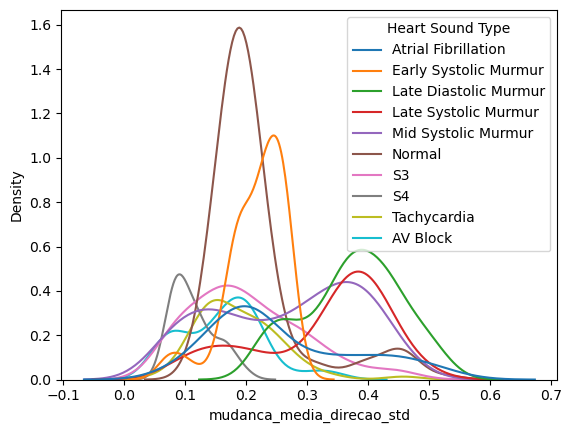

In [19]:
import seaborn as sns
sns.kdeplot(data=df_window_summary, x="mudanca_media_direcao_std",
            hue="Heart Sound Type")  # ou outro target

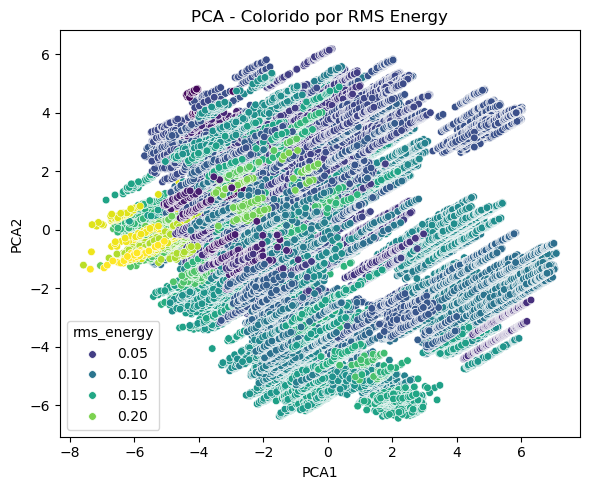

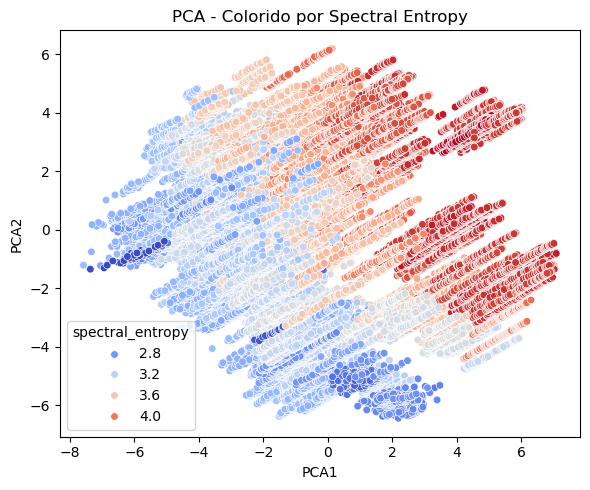

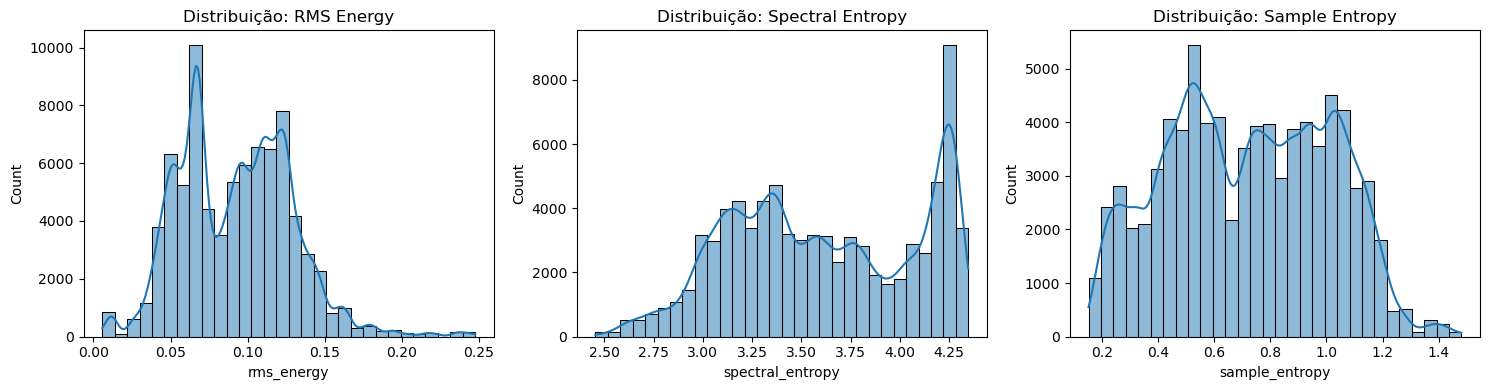

(np.float64(1.0), np.float64(0.0))

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. PCA com coloração por RMS energy e Spectral Entropy
df_plot = df_sem_cod_HS.copy()
features_for_pca = df_plot.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id"], errors="ignore")
X_scaled = StandardScaler().fit_transform(features_for_pca.drop(
    columns=["rms_energy", "spectral_entropy", "sample_entropy"], errors="ignore"))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_plot["PCA1"] = X_pca[:, 0]
df_plot["PCA2"] = X_pca[:, 1]

# Gráfico 1: Colorido por RMS Energy
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_plot, x="PCA1", y="PCA2",
                hue="rms_energy", palette="viridis", s=30)
plt.title("PCA - Colorido por RMS Energy")
plt.tight_layout()
plt.show()

# Gráfico 2: Colorido por Spectral Entropy
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_plot, x="PCA1", y="PCA2",
                hue="spectral_entropy", palette="coolwarm", s=30)
plt.title("PCA - Colorido por Spectral Entropy")
plt.tight_layout()
plt.show()

# 2. Histogramas das features adicionais

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df_plot["rms_energy"], bins=30, ax=axs[0], kde=True)
axs[0].set_title("Distribuição: RMS Energy")

sns.histplot(df_plot["spectral_entropy"], bins=30, ax=axs[1], kde=True)
axs[1].set_title("Distribuição: Spectral Entropy")

sns.histplot(df_plot["sample_entropy"], bins=30, ax=axs[2], kde=True)
axs[2].set_title("Distribuição: Sample Entropy")

plt.tight_layout()
plt.show()

# 3. Teste simples com Random Forest (validação cruzada binária fictícia)
# Simulando uma coluna binária para teste
df_plot["label"] = (df_plot["sample_entropy"] >
                    df_plot["sample_entropy"].median()).astype(int)

X_model = df_plot.select_dtypes(include=["float64", "int"]).drop(
    columns=["window_id", "label", "PCA1", "PCA2"], errors="ignore")
y_model = df_plot["label"]

clf = RandomForestClassifier(random_state=42, n_estimators=100)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_model, y_model, cv=cv, scoring="accuracy")

# Resultado do modelo simples
scores.mean(), scores.std()